# Requirements

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense

# Laboratory Exercise - Run Mode (8 points)

## Introduction
In this laboratory assignment, the primary objective is to use Long Short-Term Memory (LSTM) networks for time series forecasting in order to predict the current **mean temperature** in the city of Delhi. To accomplish this use data from the past three days, which includes information such as the **mean temperature**, **humidity**, **wind speed**, and **mean pressure**. The goal is to employ LSTM, a type of recurrent neural network, to effectively forecast the future mean temperature based on the provided historical data.

**Note: You are required to perform this laboratory assignment on your local machine.**

## The Climate Dataset

## Downloading the Climate Dataset

## Exploring the Climate Dataset
This dataset consists of daily weather records for the city of Delhi spanning a period of 4 years (from 2013 to 2017). The dataset includes the following attributes:

- date - date in the format YYYY-MM-DD,
- meantemp - mean temperature averaged from multiple 3-hour intervals in a day,
- humidity - humidity value for the day (measured in grams of water vapor per cubic meter volume of air),
- wind_speed - wind speed measured in kilometers per hour, and
- meanpressure - pressure reading of the weather (measured in atm).

*Note: The dataset is complete, with no missing values in any of its entries.*

Load the dataset into a `pandas` data frame.

In [2]:
data = pd.read_csv('data/climate-data.csv')

In [3]:
data.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [4]:
data = data.sort_values(by=['date'])

Explore the dataset using visualizations of your choice.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB


<Axes: >

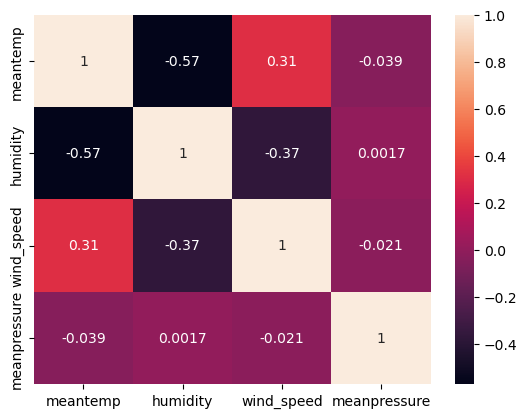

In [6]:
sns.heatmap(data.drop(columns=['date']).corr(), annot=True)

<Axes: ylabel='meantemp'>

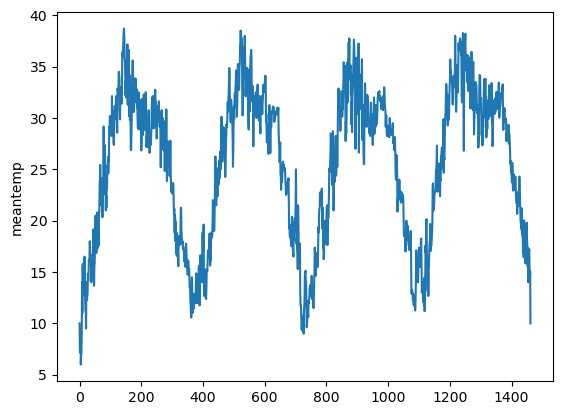

In [7]:
sns.lineplot(data['meantemp'])

## Feauture Extraction
Apply a lag of one, two, and three days to each feature, creating a set of features representing the meteorological conditions from the previous three days. To maintain dataset integrity, eliminate any resulting missing values at the beginning of the dataset.

*Be careful when extracting the features. For each day, ensure that features are obtained sequentially, starting with those from 3 days ago, followed by features from 2 days ago, and finally, features from 1 day ago. This becomes crucial when reshaping the train and test sets later on.*

Hint: Use `df['column_name'].shift(period)`. Check the documentation at https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html.

In [8]:
data.columns

Index(['date', 'meantemp', 'humidity', 'wind_speed', 'meanpressure'], dtype='object')

In [9]:
features = ['humidity', 'wind_speed','meanpressure']
target = ['meantemp']
all =  ['humidity', 'wind_speed','meanpressure','meantemp']

In [10]:
lags = range(3, 0, -1)
list(lags)
for lag in lags:
    for column in all:
        data[f"{column}_{lag}"] = data[column].shift(lag)
data

,date,meantemp,humidity,wind_speed,meanpressure,humidity_3,wind_speed_3,meanpressure_3,meantemp_3,humidity_2,wind_speed_2,meanpressure_2,meantemp_2,humidity_1,wind_speed_1,meanpressure_1,meantemp_1
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,84.500000,0.000000,1015.666667,10.000000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667,NaN,NaN,NaN,NaN,84.500000,0.000000,1015.666667,10.000000,92.000000,2.980000,1017.800000,7.400000
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667,84.500000,0.000000,1015.666667,10.000000,92.000000,2.980000,1017.800000,7.400000,87.000000,4.633333,1018.666667,7.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000,92.000000,2.980000,1017.800000,7.400000,87.000000,4.633333,1018.666667,7.166667,71.333333,1.233333,1017.166667,8.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217,94.300000,9.085000,1014.350000,14.000000,74.857143,8.784211,1016.952381,17.142857,67.550000,8.335000,1017.200000,16.850000
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762,74.857143,8.784211,1016.952381,17.142857,67.550000,8.335000,1017.200000,16.850000,68.043478,3.547826,1015.565217,17.217391
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762,67.550000,8.335000,1017.200000,16.850000,68.043478,3.547826,1015.565217,17.217391,87.857143,6.000000,1016.904762,15.238095
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000,68.043478,3.547826,1015.565217,17.217391,87.857143,6.000000,1016.904762,15.238095,89.666667,6.266667,1017.904762,14.095238


In [11]:
data = data.dropna(axis=0)

In [12]:
data = data.drop(columns=features)

In [13]:
data

,date,meantemp,humidity_3,wind_speed_3,meanpressure_3,meantemp_3,humidity_2,wind_speed_2,meanpressure_2,meantemp_2,humidity_1,wind_speed_1,meanpressure_1,meantemp_1
3,2013-01-04,8.666667,84.500000,0.000000,1015.666667,10.000000,92.000000,2.980000,1017.800000,7.400000,87.000000,4.633333,1018.666667,7.166667
4,2013-01-05,6.000000,92.000000,2.980000,1017.800000,7.400000,87.000000,4.633333,1018.666667,7.166667,71.333333,1.233333,1017.166667,8.666667
5,2013-01-06,7.000000,87.000000,4.633333,1018.666667,7.166667,71.333333,1.233333,1017.166667,8.666667,86.833333,3.700000,1016.500000,6.000000
6,2013-01-07,7.000000,71.333333,1.233333,1017.166667,8.666667,86.833333,3.700000,1016.500000,6.000000,82.800000,1.480000,1018.000000,7.000000
7,2013-01-08,8.857143,86.833333,3.700000,1016.500000,6.000000,82.800000,1.480000,1018.000000,7.000000,78.600000,6.300000,1020.000000,7.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1457,2016-12-28,17.217391,94.300000,9.085000,1014.350000,14.000000,74.857143,8.784211,1016.952381,17.142857,67.550000,8.335000,1017.200000,16.850000
1458,2016-12-29,15.238095,74.857143,8.784211,1016.952381,17.142857,67.550000,8.335000,1017.200000,16.850000,68.043478,3.547826,1015.565217,17.217391
1459,2016-12-30,14.095238,67.550000,8.335000,1017.200000,16.850000,68.043478,3.547826,1015.565217,17.217391,87.857143,6.000000,1016.904762,15.238095
1460,2016-12-31,15.052632,68.043478,3.547826,1015.565217,17.217391,87.857143,6.000000,1016.904762,15.238095,89.666667,6.266667,1017.904762,14.095238


## Dataset Splitting
Partition the dataset into training and testing sets with an 90:10 ratio.

**WARNING: DO NOT SHUFFLE THE DATASET.**



In [14]:
X, y = data.drop(columns=['meantemp','date']), data['meantemp']

In [15]:
X_train,X_test,Y_train,Y_test = train_test_split(X,y,test_size=0.1,shuffle=False,random_state=43)

## Feauture Scaling
Scale the extracted features using an appropriate scaler.

In [16]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Feature Reshaping

Reshape the feature dimensions into the shape `(samples, timesteps, features)`.

In [17]:
scaler = MinMaxScaler()
Y_train = scaler.fit_transform(Y_train.to_numpy().reshape(-1, 1))

In [18]:
lag = 3
(X_train.shape[0], lag, (X_train.shape[1] // lag))

(1313, 3, 4)

In [19]:
X_train = X_train.reshape((X_train.shape[0], lag, (X_train.shape[1] // lag)))
X_test = X_test.reshape((X_test.shape[0], lag, (X_test.shape[1] // lag)))

## Long Short-Term Memory (LSTM) Network
Build a Long Short-Term Memory (LSTM) Network for forecasting the current **mean temperature** based on the extracted features from the previous three days.

Define the forecasting model using the **Keras Sequential API** (`keras.models.Sequential`), incorporating one or more LSTM layers along with additional relevant layers (`keras.layers`). Be cautious when specifying the configuration of the final layer to ensure proper model output for the forecasting task.

In [20]:
model = Sequential([
    Input((X_train.shape[1], X_train.shape[2],)),
    LSTM(64, activation="relu", return_sequences=True),
    LSTM(32, activation="relu"),
    Dense(1, activation="linear")
])

Compile the previously defined model specifying **loss function** (`keras.losses`), **optimizer** (`keras.optimizers`) and **evaluation metrics** (`keras.metics`).

In [21]:
model.compile(
    loss="mean_squared_error",
    optimizer="adam",
    metrics=["mean_squared_error"],
)

Train the model on the training set, specifying the **batch size** and **number of epochs** for the training process. Allocate 20% of the samples for **validation**, and ensure that the dataset remains **unshuffled** during training.

In [22]:
history = model.fit(X_train, Y_train, validation_split=0.20, epochs=16, batch_size=64, shuffle=False)

Epoch 1/16
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - loss: 0.3483 - mean_squared_error: 0.3483 - val_loss: 0.3376 - val_mean_squared_error: 0.3376
Epoch 2/16
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.2504 - mean_squared_error: 0.2504 - val_loss: 0.1848 - val_mean_squared_error: 0.1848
Epoch 3/16
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1015 - mean_squared_error: 0.1015 - val_loss: 0.0439 - val_mean_squared_error: 0.0439
Epoch 4/16
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0473 - mean_squared_error: 0.0473 - val_loss: 0.0356 - val_mean_squared_error: 0.0356
Epoch 5/16
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0317 - mean_squared_error: 0.0317 - val_loss: 0.0256 - val_mean_squared_error: 0.0256
Epoch 6/16
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0224 - mean_squared_error: 0.0224 - val_loss: 0.0156 - val_mean_squared_error: 0.0156
Epoch 7/16
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0147 - mean_squared_error: 0.0147 - val_loss: 0.0094 - v

Create a line plot illustrating both the **training** and **validation loss** over the training epochs.

<Axes: >

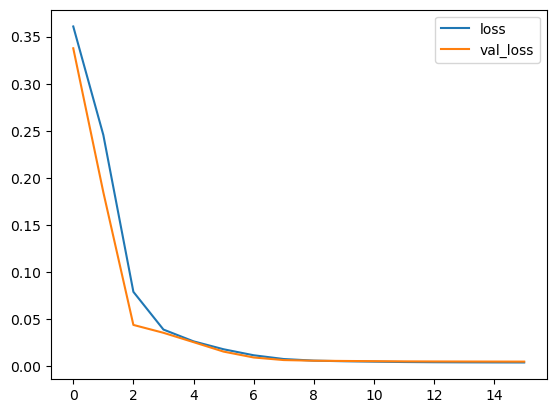

In [23]:
sns.lineplot(history.history["loss"], label="loss")
sns.lineplot(history.history["val_loss"], label="val_loss")

Use the trained model to make predictions for the test set.

In [24]:
y_pred = model.predict(X_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 209ms/step


In [25]:
y_pred = scaler.inverse_transform(y_pred)

Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [26]:
(mean_absolute_error(Y_test, y_pred), mean_squared_error(Y_test, y_pred), r2_score(Y_test, y_pred))

(1.2158998495901723, 2.389588891184321, 0.9266163203466617)

Create a line plot in order to compare the actual and predicted mean temperatures for the test set.

<Axes: xlabel='None'>

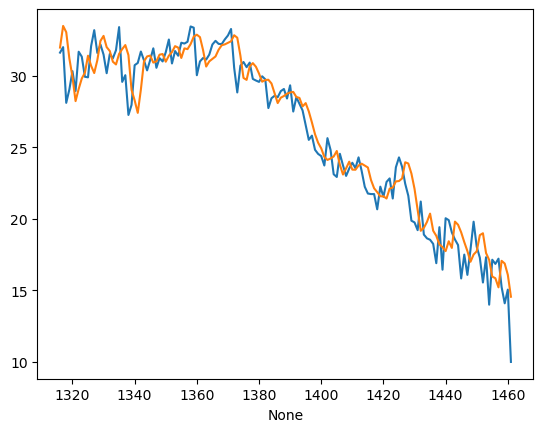

In [27]:
sns.lineplot(x=Y_test.index, y=Y_test.values)
sns.lineplot(x=Y_test.index, y=y_pred.flatten())

# Laboratory Exercise - Bonus Task (+ 2 points)

As a bonus task for this laboratory exercise, calculate the Simple Moving Average (SMA) and Weighted Moving Average (WMA) with 3 timesteps for `mean_temperature` over the past 1, 2, and 3 days:

- **SMA with 3 timesteps ($\text{SMA}_3$)** - the average of temperatures from the previous 3 days:  
  $SMA_3 = \frac{\text{mean\_temperaure}_{lag\_3} +\ \text{mean\_temperaure}_{lag\_2} +\ \text{mean\_temperaure}_{lag\_1}}{1\ +\ 1\ +\ 1}$.

- **WMA with 3 timesteps ($\text{WMA}_3$)** - a weighted average, giving more importance to recent days:  
  $WMA_3 = \frac{1\ \cdot\ \text{mean\_temperaure}_{lag\_3} +\ 2\ \cdot\ \text{mean\_temperaure}_{lag\_2} +\ 3\ \cdot\ \text{mean\_temperaure}_{lag_1}}{1\ +\ 2\ +\ 3}$.

Then use this indicators alongside the other features in the dataset to predict the `mean_temperaure`.

*Hint: Use the `rolling` method from `pandas`. Check the docs at the following link https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html.*

In [30]:
data['sma_3'] = data['meantemp'].rolling(window=3).mean()

In [38]:
weights = [1,2,3]
def calculate_wma(series):
    return sum(series[i] * weights[i] for i in range(len(weights))) / sum(weights)

In [40]:
data['WMA_3'] = (
    data['meantemp']
    .rolling(window=3)
    .apply(calculate_wma, raw=True)
)

In [46]:
data = data.dropna()

In [48]:
X, y = data.drop(columns=['meantemp','date']), data['meantemp']

In [50]:
X_train,X_test,Y_train,Y_test = train_test_split(X,y,test_size=0.1,shuffle=False,random_state=43)

In [51]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [52]:
scaler = MinMaxScaler()
Y_train = scaler.fit_transform(Y_train.to_numpy().reshape(-1, 1))

In [58]:
lag = 2
(X_train.shape[0], lag, (X_train.shape[1] // lag))

(1311, 2, 7)

In [59]:
X_train = X_train.reshape((X_train.shape[0], lag, (X_train.shape[1] // lag)))
X_test = X_test.reshape((X_test.shape[0], lag, (X_test.shape[1] // lag)))

In [88]:
model = Sequential([
    Input((X_train.shape[1], X_train.shape[2],)),
    LSTM(64, activation="relu", return_sequences=True),
    LSTM(32, activation="relu"),
    Dense(1, activation="linear")
])

In [89]:
model.compile(
    loss="mean_squared_error",
    optimizer="adam",
    metrics=["mean_squared_error"],
)

In [90]:
history = model.fit(X_train, Y_train, validation_split=0.20, epochs=16, batch_size=64, shuffle=False)

Epoch 1/16
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - loss: 0.3459 - mean_squared_error: 0.3459 - val_loss: 0.3486 - val_mean_squared_error: 0.3486
Epoch 2/16
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2667 - mean_squared_error: 0.2667 - val_loss: 0.2246 - val_mean_squared_error: 0.2246
Epoch 3/16
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1396 - mean_squared_error: 0.1396 - val_loss: 0.0503 - val_mean_squared_error: 0.0503
Epoch 4/16
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0360 - mean_squared_error: 0.0360 - val_loss: 0.0343 - val_mean_squared_error: 0.0343
Epoch 5/16
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0338 - mean_squared_error: 0.0338 - val_loss: 0.0312 - val_mean_squared_error: 0.0312
Epoch 6/16
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0266 - mean_squared_error: 0.0266 - val_loss: 0.0237 - val_mean_squared_error: 0.0237
Epoch 7/16
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0233 - mean_squared_error: 0.0233 - val_loss: 0.0193 - v

<Axes: >

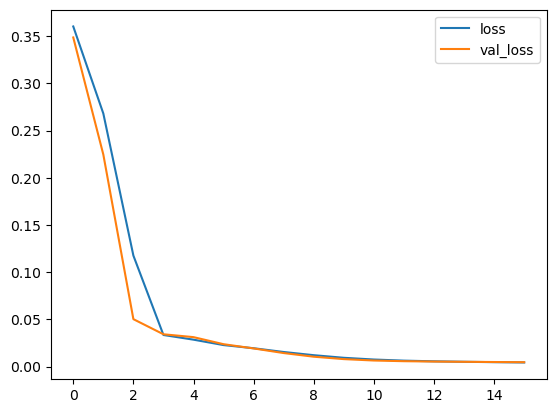

In [91]:
sns.lineplot(history.history["loss"], label="loss")
sns.lineplot(history.history["val_loss"], label="val_loss")

In [92]:
y_pred = model.predict(X_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step


In [93]:
y_pred = scaler.inverse_transform(y_pred)

In [94]:
(mean_absolute_error(Y_test, y_pred), mean_squared_error(Y_test, y_pred), r2_score(Y_test, y_pred))

(1.1375138272709924, 2.173110621740344, 0.9332643140812293)

<Axes: xlabel='None'>

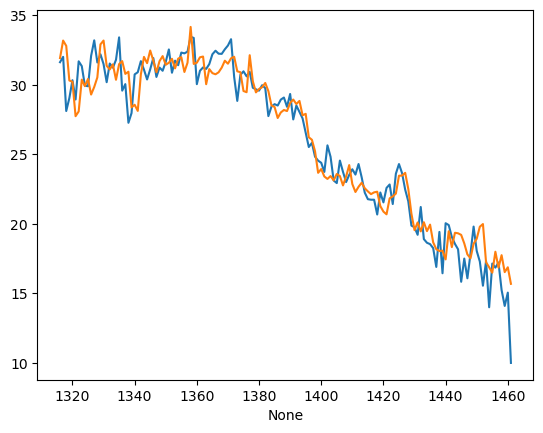

In [95]:
sns.lineplot(x=Y_test.index, y=Y_test.values)
sns.lineplot(x=Y_test.index, y=y_pred.flatten())